# Project

## Table of Contents

## Imports

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import cross_validate

from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import GridSearchCV, learning_curve

from joblib import dump, load
from os.path import exists

import matplotlib.pyplot as plt

## Data Exploration

[Jump](#test) to early findings

In [2]:
train_df = pd.read_csv('./dataset/train.csv')
test_df = pd.read_csv('./dataset/test.csv')

# used ONLY for viewing data trends NOT FOR TRAINING
datasets = pd.concat([train_df, test_df], axis=0)

datasets.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1309 entries, 0 to 417
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  1309 non-null   int64  
 1   Survived     891 non-null    float64
 2   Pclass       1309 non-null   int64  
 3   Name         1309 non-null   object 
 4   Sex          1309 non-null   object 
 5   Age          1046 non-null   float64
 6   SibSp        1309 non-null   int64  
 7   Parch        1309 non-null   int64  
 8   Ticket       1309 non-null   object 
 9   Fare         1308 non-null   float64
 10  Cabin        295 non-null    object 
 11  Embarked     1307 non-null   object 
dtypes: float64(3), int64(4), object(5)
memory usage: 132.9+ KB


In [3]:
print(f"Train:\n{train_df.isna().sum()}\n")
print(f"Test:\n{test_df.isna().sum()}\n")
print(f"ALL:\n{datasets.isna().sum()}\n")

Train:
PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

Test:
PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64

ALL:
PassengerId       0
Survived        418
Pclass            0
Name              0
Sex               0
Age             263
SibSp             0
Parch             0
Ticket            0
Fare              1
Cabin          1014
Embarked          2
dtype: int64



In [4]:
datasets.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0.0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1.0,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0.0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


<a id='test'></a>
Looking at the data, here's what I found:

#### All Data
* PassengerId is uneccessary for training, so I'll drop it. **However, it is also used for submission so it will need to be readded later.**
* Name is uneccessary for training, so I'll drop it.
* Ticket has some really odd values, so I'll drop it for the time being, I'll add it later if I change my mind.

#### Train
We have some missing data cells from these features:
* Age - we have 177 missing cells.
* Cabin - we have 687 missing cells.
* Embarked - we have 2 missing cells.

We will have to fill these missing cells later.

#### Test
We have some missing data cells from these features:
* Age - we have 86 missing cells.
* Fare - we have 1 missing cells.
* Cabin - we have 327 missing cells.

We will have to fill these missing cells later.

Due to such a large amount of missing values for Cabin in both the training and test data, I will drop this feature for now.

#### Now lets see the distributions of each categorical feature and their effects on survivability in train_df.

### Survived

Text(0.5, 1.0, 'Survival Rate')

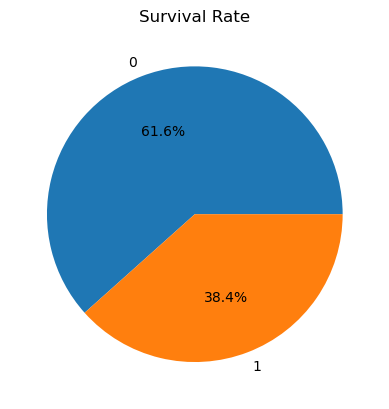

In [5]:
data = train_df['Survived'].value_counts()
plt.pie(data, labels= data.index,
    autopct= '%1.1f%%'
)
plt.title('Survival Rate')

### Age, SibSp, Parch, Fare (Numerical)

In [6]:
to_hist = ['Age', 'SibSp','Parch','Fare']

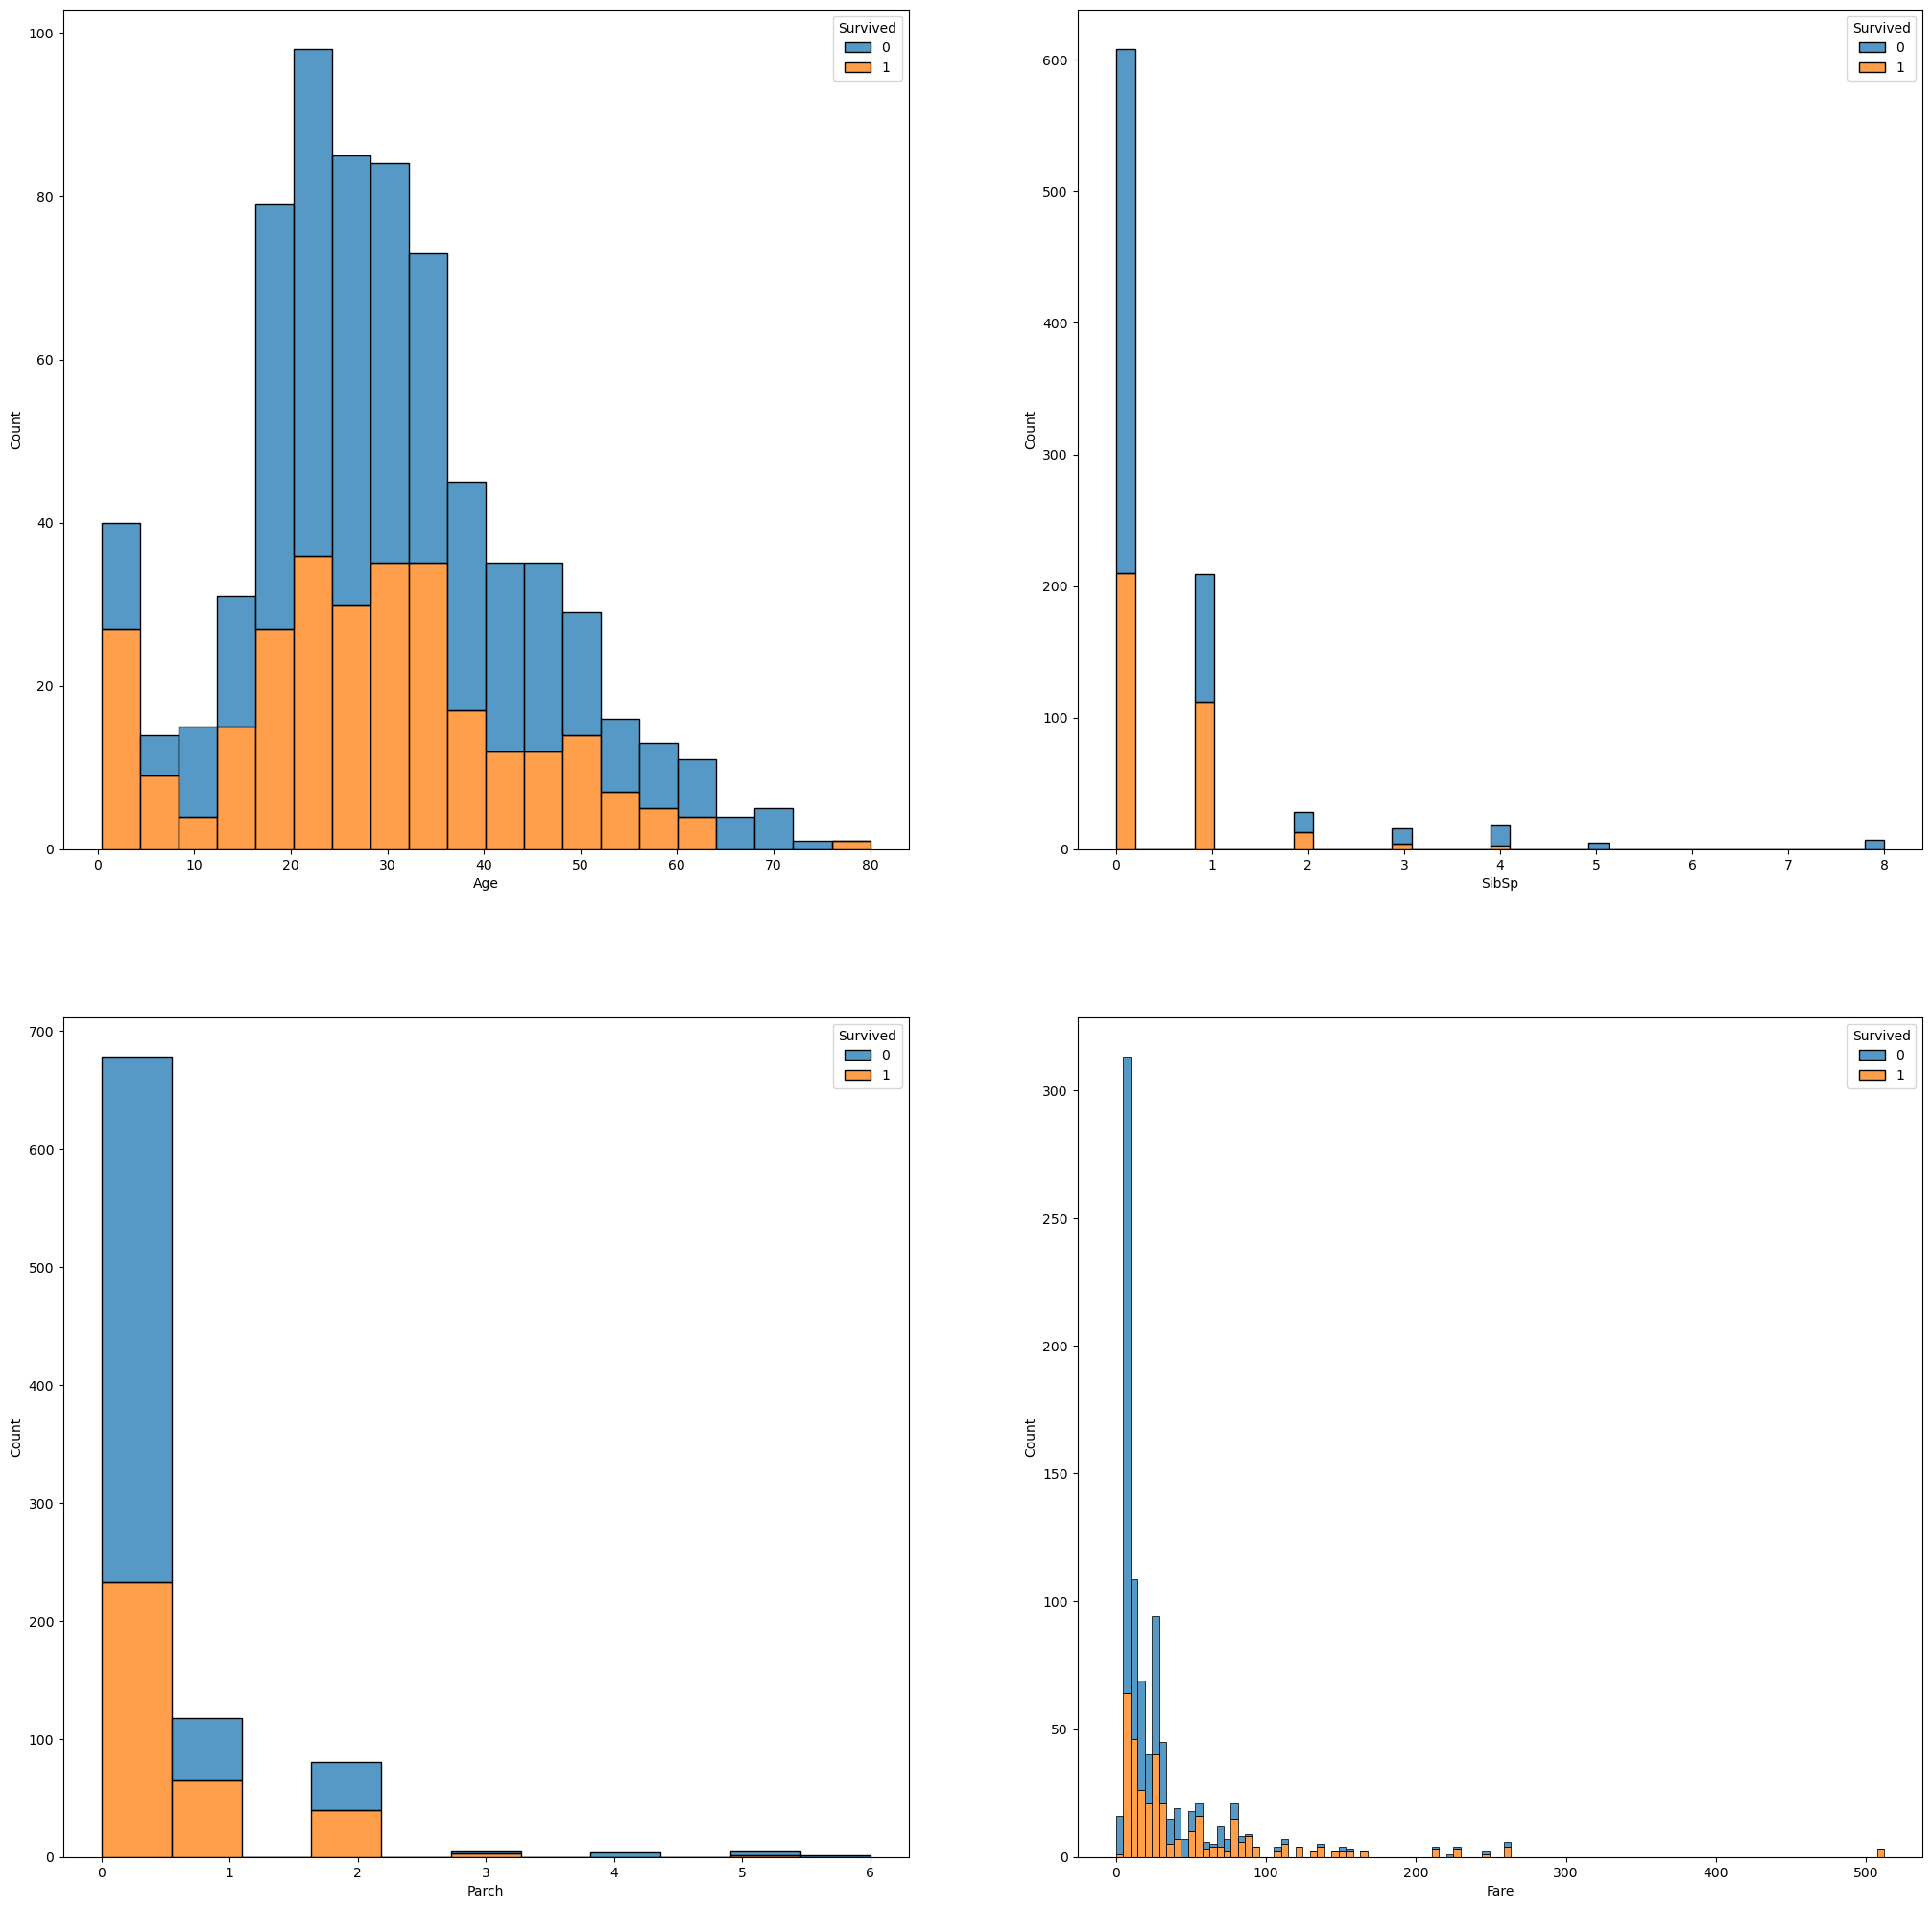

In [7]:
fig, axes = plt.subplots(2, 2, figsize=(25,25))

for i in range(2):
    for j in range(2):
        idx = (i*2)+j
        
        sns.histplot(x=to_hist[idx], hue='Survived', multiple='stack', data=train_df, ax=axes[i, j])

plt.show()  

### Pclass, Sex, Embarked (Categorical)

In [8]:
to_cross = ['Pclass', 'Sex', 'Embarked']

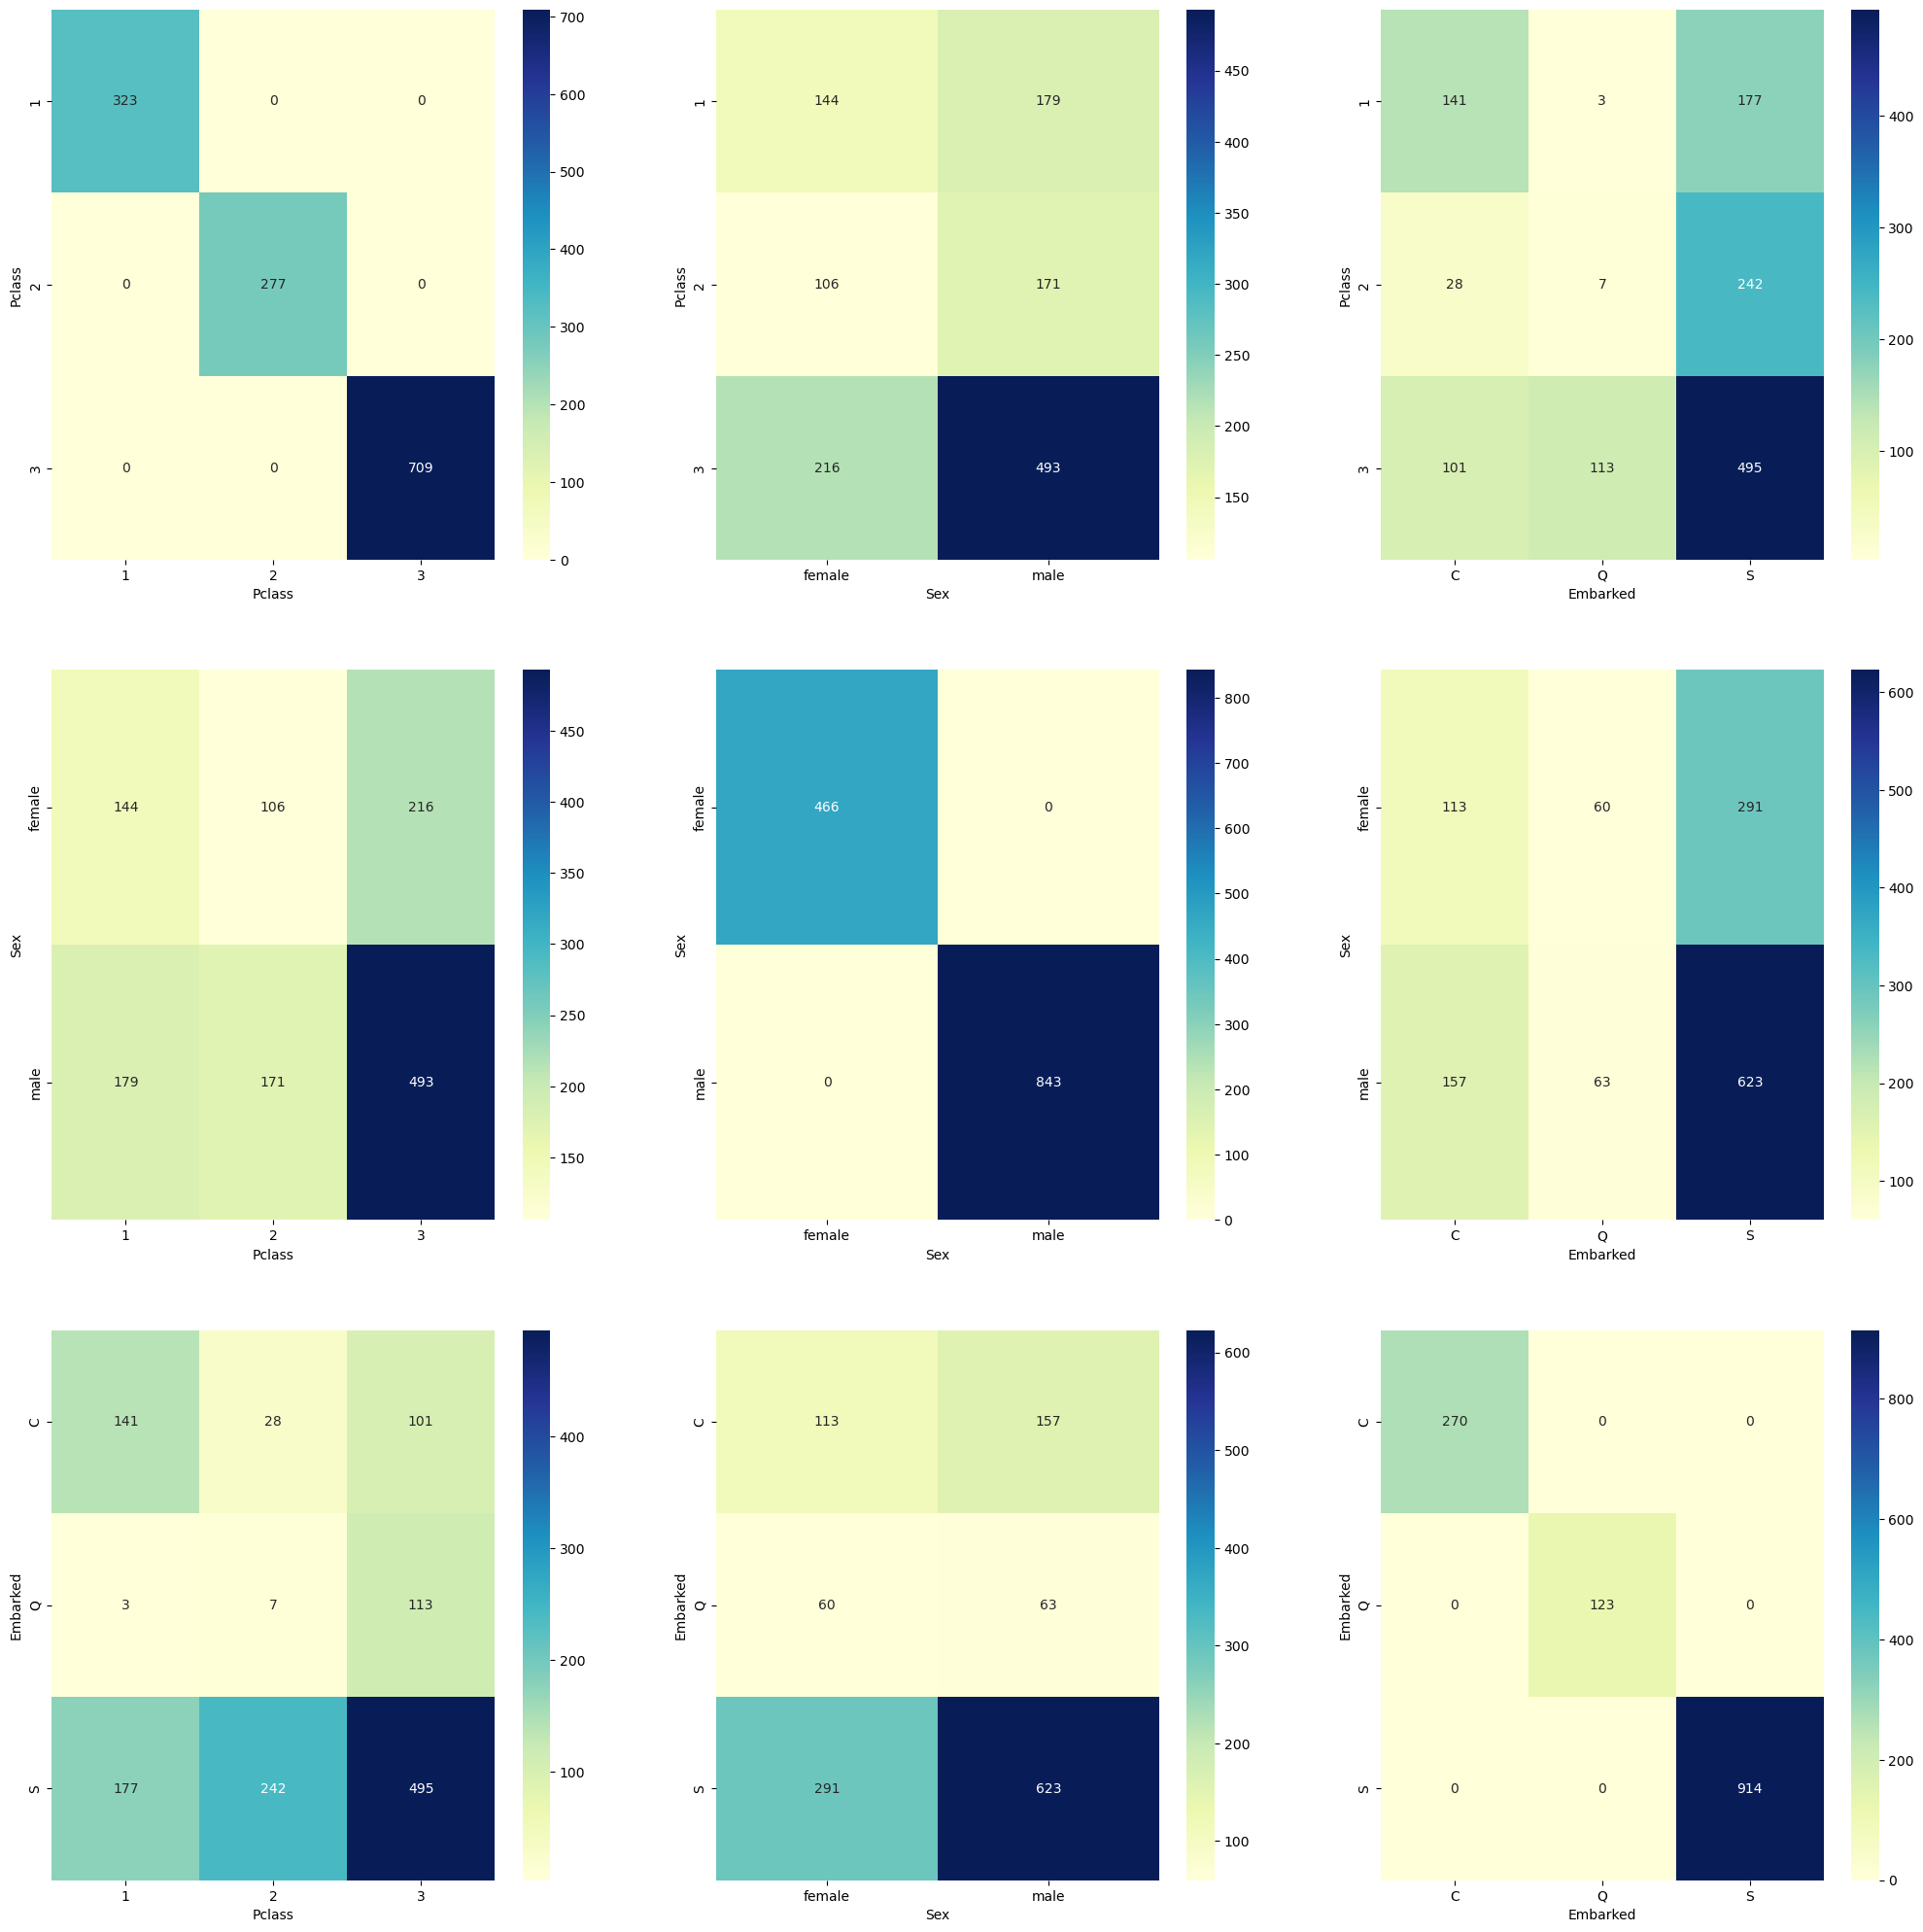

In [9]:
fig, axes = plt.subplots(3, 3, figsize=(25,25))

for i in range(3):
    for j in range(3):
        cross_tab = pd.crosstab(datasets[to_cross[i]], datasets[to_cross[j]])
        sns.heatmap(cross_tab, annot=True, cmap='YlGnBu', fmt='g', cbar=True, ax=axes[i, j])
plt.show()

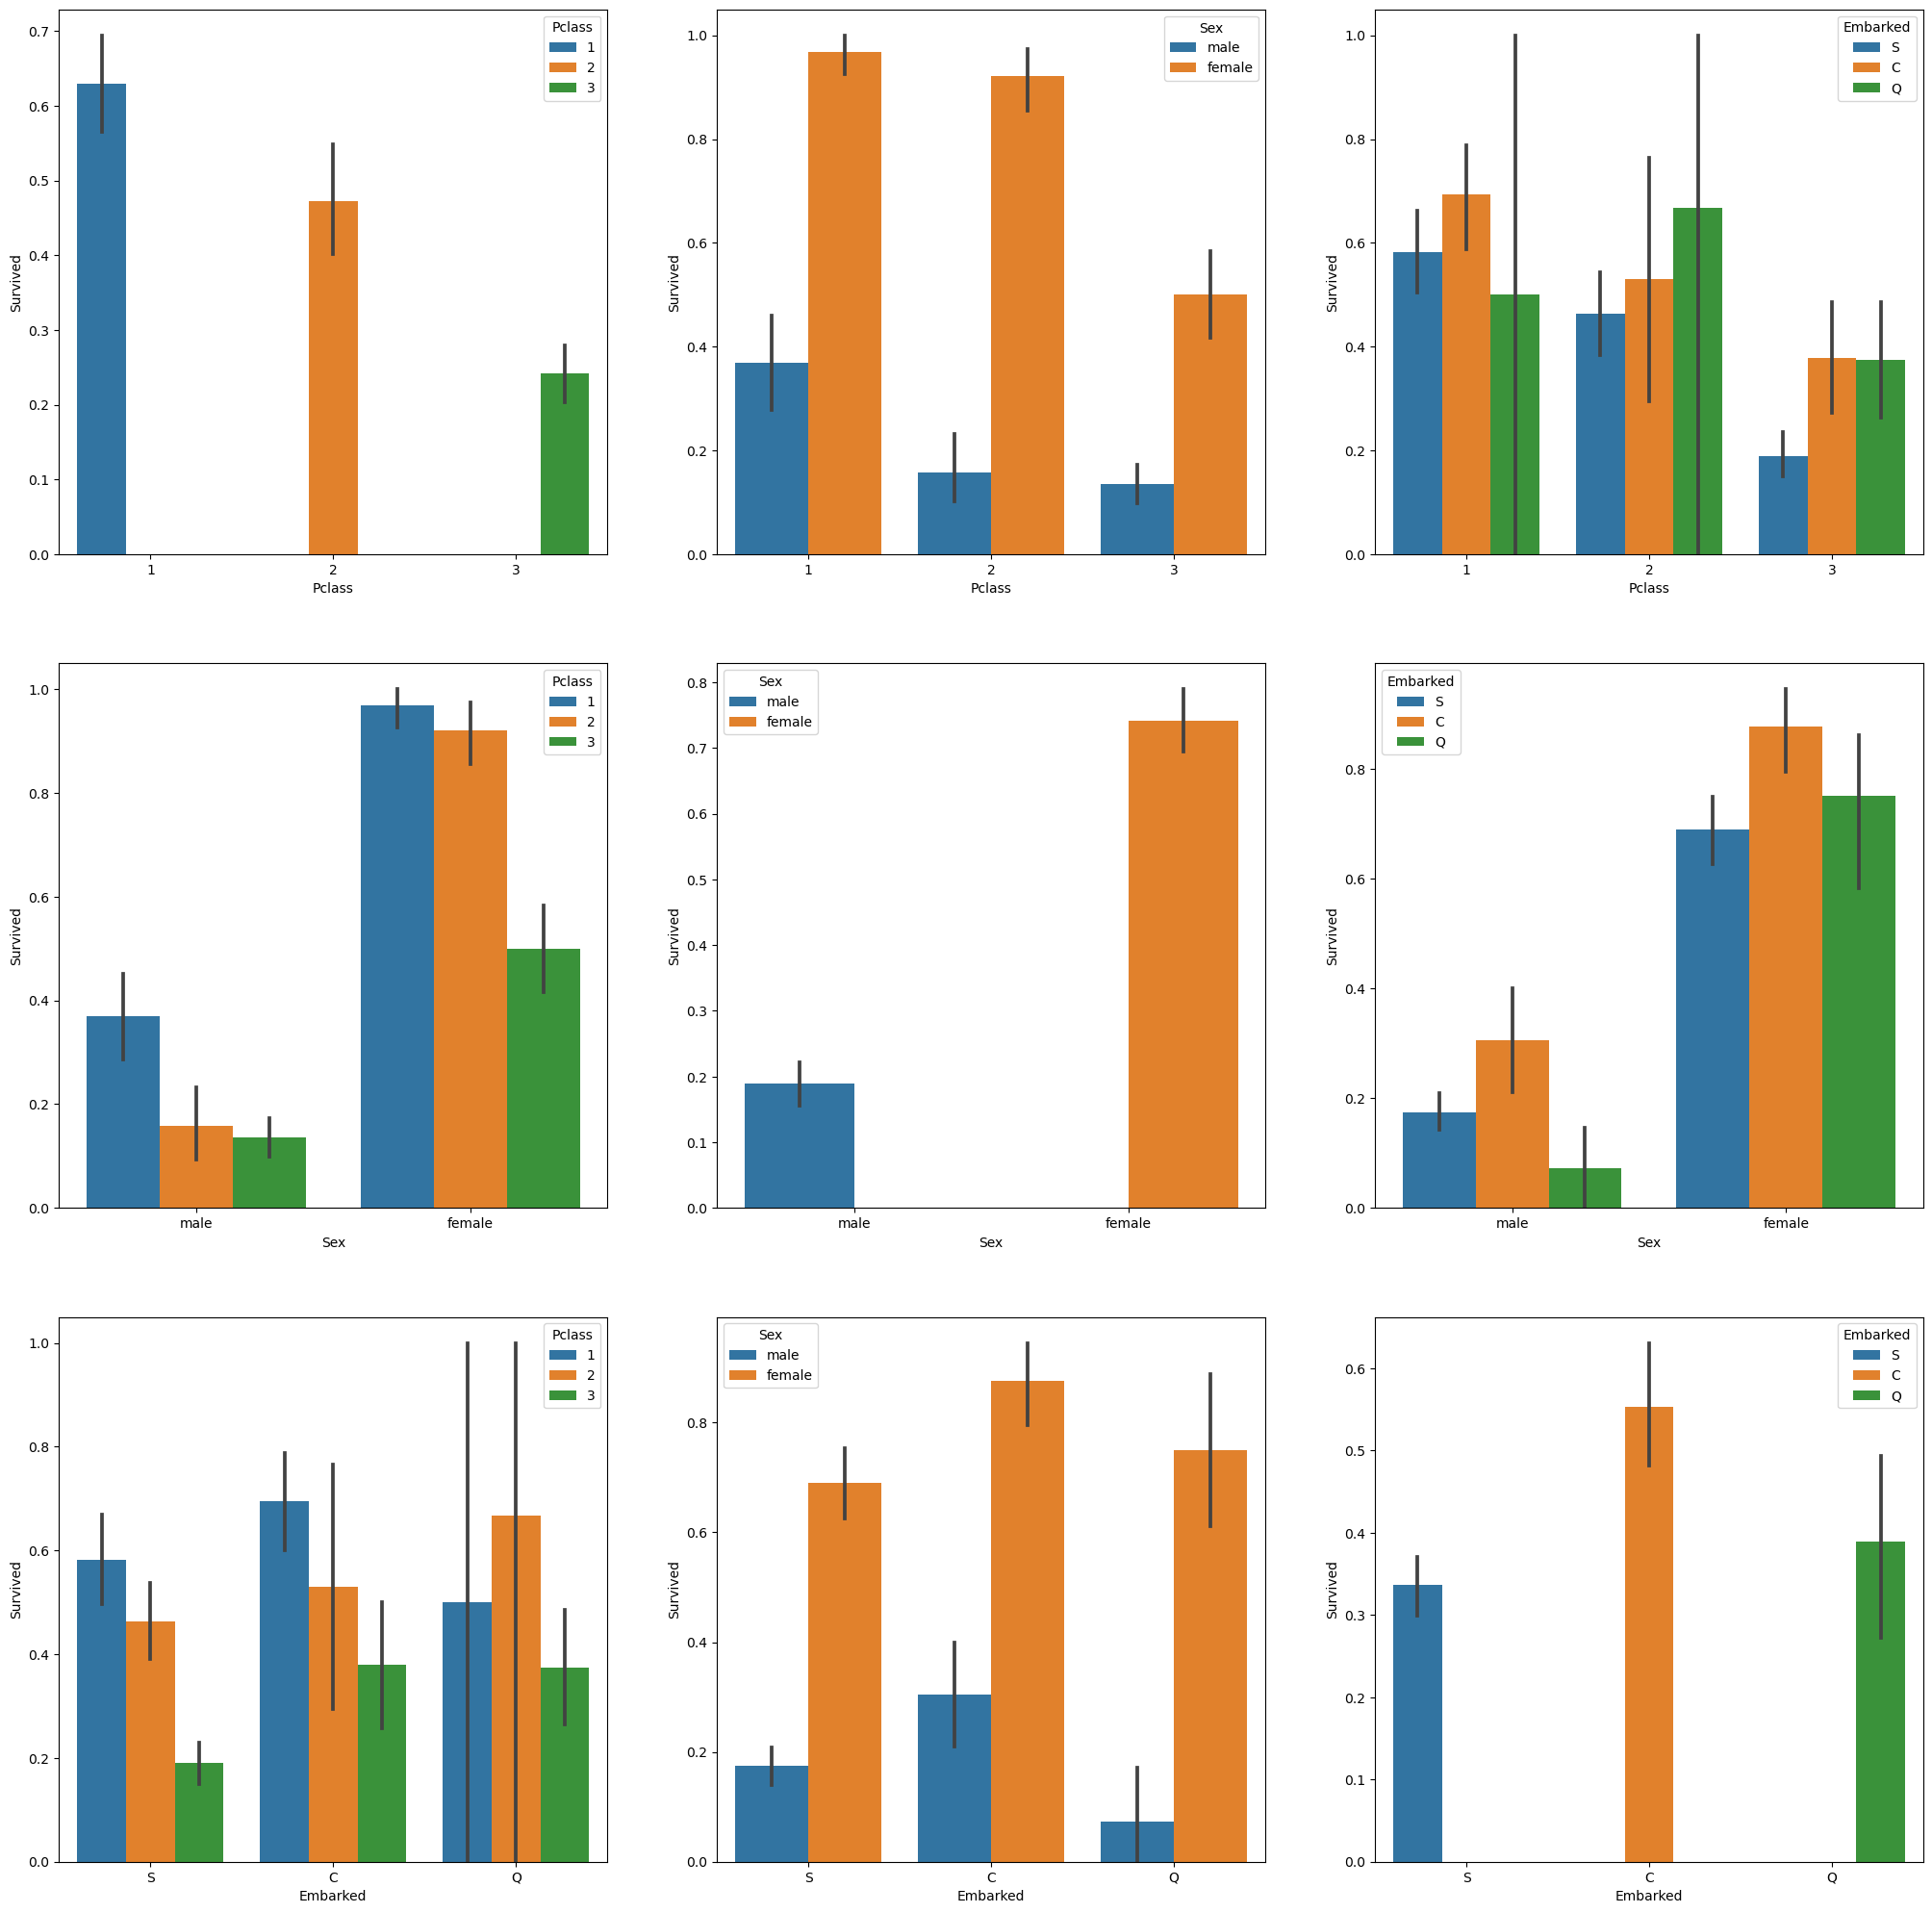

In [10]:
fig, axes = plt.subplots(3, 3, figsize=(25,25))

for i in range(3):
    for j in range(3):
        sns.barplot(x=to_cross[i], y='Survived', hue=to_cross[j], data=train_df, ax=axes[i, j])
plt.show()

### Name, Ticket, Cabin (Distinct)

In [11]:
for var in ['Name','Ticket','Cabin']:
    distinct_count = len(datasets[var].unique())
    print(f'Distinct count of {var}: {distinct_count}')

Distinct count of Name: 1307
Distinct count of Ticket: 929
Distinct count of Cabin: 187


## Feature Engineering

### Name, Ticket, Cabin (Distinct)

#### Name

In [12]:
datasets['Name'].head(15)

0                               Braund, Mr. Owen Harris
1     Cumings, Mrs. John Bradley (Florence Briggs Th...
2                                Heikkinen, Miss. Laina
3          Futrelle, Mrs. Jacques Heath (Lily May Peel)
4                              Allen, Mr. William Henry
5                                      Moran, Mr. James
6                               McCarthy, Mr. Timothy J
7                        Palsson, Master. Gosta Leonard
8     Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)
9                   Nasser, Mrs. Nicholas (Adele Achem)
10                      Sandstrom, Miss. Marguerite Rut
11                             Bonnell, Miss. Elizabeth
12                       Saundercock, Mr. William Henry
13                          Andersson, Mr. Anders Johan
14                 Vestrom, Miss. Hulda Amanda Adolfina
Name: Name, dtype: object

In [13]:
datasets['Title'] = datasets['Name'].apply(lambda x: x.split(', ')[1].split('.')[0])

print(datasets['Title'].value_counts())

Title
Mr              757
Miss            260
Mrs             197
Master           61
Rev               8
Dr                8
Col               4
Mlle              2
Major             2
Ms                2
Lady              1
Sir               1
Mme               1
Don               1
Capt              1
the Countess      1
Jonkheer          1
Dona              1
Name: count, dtype: int64


Title
Mr        757
Miss      260
Mrs       197
Master     61
Misc       34
Name: count, dtype: int64


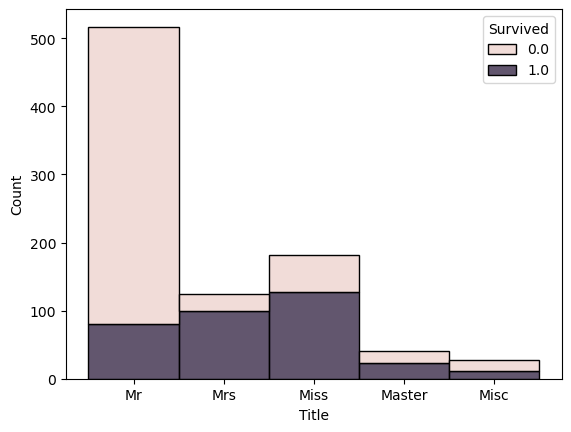

In [14]:
title_count = datasets['Title'].value_counts()
datasets['Title'] = datasets['Title'].apply(lambda x: x if title_count[x] > 10 else 'Misc')
sns.histplot(x='Title', hue='Survived', multiple='stack', data=datasets)

print(datasets['Title'].value_counts())

#### Ticket (Replaced)

In [15]:
datasets['Ticket'].head(15)

0            A/5 21171
1             PC 17599
2     STON/O2. 3101282
3               113803
4               373450
5               330877
6                17463
7               349909
8               347742
9               237736
10             PP 9549
11              113783
12           A/5. 2151
13              347082
14              350406
Name: Ticket, dtype: object

In [16]:
datasets['Ticket'].sort_values().head(15)

504    110152
257    110152
759    110152
585    110413
262    110413
558    110413
110    110465
475    110465
335    110469
158    110489
430    110564
366    110813
236    110813
191    111163
170    111240
Name: Ticket, dtype: object

In [17]:
datasets[datasets['Ticket'].isin(['110152','110413','110465'])].sort_values('Ticket')

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title
257,258,1.0,1,"Cherry, Miss. Gladys",female,30.0,0,0,110152,86.50,B77,S,Miss
504,505,1.0,1,"Maioni, Miss. Roberta",female,16.0,0,0,110152,86.50,B79,S,Miss
759,760,1.0,1,"Rothes, the Countess. of (Lucy Noel Martha Dye...",female,33.0,0,0,110152,86.50,B77,S,Misc
262,263,0.0,1,"Taussig, Mr. Emil",male,52.0,1,1,110413,79.65,E67,S,Mr
558,559,1.0,1,"Taussig, Mrs. Emil (Tillie Mandelbaum)",female,39.0,1,1,110413,79.65,E67,S,Mrs
585,586,1.0,1,"Taussig, Miss. Ruth",female,18.0,0,2,110413,79.65,E68,S,Miss
110,111,0.0,1,"Porter, Mr. Walter Chamberlain",male,47.0,0,0,110465,52.00,C110,S,Mr
475,476,0.0,1,"Clifford, Mr. George Quincy",male,NaN,0,0,110465,52.00,A14,S,Mr


In [18]:
ticket_count = datasets['Ticket'].value_counts()
datasets['Solo'] = datasets['Ticket'].apply(lambda x: 0 if ticket_count[str(x)]<=1 else 1)
datasets['Solo'].value_counts()

Solo
0    713
1    596
Name: count, dtype: int64

In [19]:
datasets['GroupSize'] = datasets['Ticket'].apply(lambda x: ticket_count[str(x)])
datasets['GroupSize'].value_counts()

GroupSize
1     713
2     264
3     147
4      64
5      35
7      35
6      24
8      16
11     11
Name: count, dtype: int64

#### Cabin (NEW)

In [20]:
datasets['Cabin'].head(15)

0      NaN
1      C85
2      NaN
3     C123
4      NaN
5      NaN
6      E46
7      NaN
8      NaN
9      NaN
10      G6
11    C103
12     NaN
13     NaN
14     NaN
Name: Cabin, dtype: object

In [21]:
datasets['Cabin'].sort_values().head(25)

583     A10
208     A11
475     A14
556     A16
331     A18
284     A19
599     A20
28      A21
630     A23
867     A24
647     A26
112     A29
209     A31
185     A32
293     A34
374     A34
445     A34
806     A36
96       A5
23       A6
174      A7
46       A9
166     B10
737    B101
815    B102
Name: Cabin, dtype: object

In [22]:
temp = pd.DataFrame()
temp['has_cabin'] = datasets['Cabin'].apply(lambda x: 0 if pd.isna(x) else 1)
temp['Pclass'] = datasets['Pclass']
temp[['Pclass','has_cabin']].value_counts().sort_index()

Pclass  has_cabin
1       0             67
        1            256
2       0            254
        1             23
3       0            693
        1             16
Name: count, dtype: int64

In [23]:
datasets['nf_Cabin'] = datasets['Cabin'].apply(lambda x:str(x)[0])
datasets['nf_Cabin'].value_counts()

nf_Cabin
n    1014
C      94
B      65
D      46
E      41
A      22
F      21
G       5
T       1
Name: count, dtype: int64

In [24]:
def change_cabin_letter(pclass,cabin_code):
    if pclass == 1 and cabin_code == 'n':
        return 'C'
    elif pclass == 2 and cabin_code == 'n':
        return 'D'
    elif pclass == 3 and cabin_code == 'n':
        return 'G'
    elif cabin_code == 'T':
        return 'C'
    else:
        return cabin_code

In [25]:
datasets['nf_Cabin'] = datasets.apply(lambda x: change_cabin_letter(x.Pclass,x.nf_Cabin),axis=1)
datasets.groupby('nf_Cabin')['Survived'].mean('Survived')

nf_Cabin
A    0.466667
B    0.744681
C    0.540000
D    0.492537
E    0.750000
F    0.615385
G    0.238095
Name: Survived, dtype: float64

### Age, SibSp, Parch, Fare (Numerical)

#### Age

In [26]:
print(datasets.groupby(['Pclass', 'Sex']).median('Age')['Age'])
median_ages = datasets.groupby(['Pclass', 'Sex'])['Age'].median()

def fill_age(row):
    if pd.isnull(row['Age']):
        return median_ages.loc[row['Pclass'], row['Sex']]
    else:
        return row['Age']

datasets['nf_Age'] = datasets.apply(fill_age, axis=1)

Pclass  Sex   
1       female    36.0
        male      42.0
2       female    28.0
        male      29.5
3       female    22.0
        male      25.0
Name: Age, dtype: float64


In [27]:
bins = [0, 16, float('inf')]
labels = ['Child', 'Adult']

datasets['nf_Age'] = pd.cut(datasets['nf_Age'], bins=bins, labels=labels, right=False)
print(datasets['nf_Age'].value_counts())

nf_Age
Adult    1194
Child     115
Name: count, dtype: int64


#### SibSp & Parch

##### SibSp (Sibling/Spouse)

In [28]:
bins = [0, 1, 3, float('inf')]
labels = ['0 Sib/Spouse', '1-2 Sib/Spouse', 'Over 2 Sib/Spouse']

print(datasets['SibSp'].value_counts())

datasets['nf_SibSp'] = pd.cut(datasets['SibSp'], bins=bins, labels=labels, right=False)

print(datasets['nf_SibSp'].value_counts())

SibSp
0    891
1    319
2     42
4     22
3     20
8      9
5      6
Name: count, dtype: int64
nf_SibSp
0 Sib/Spouse         891
1-2 Sib/Spouse       361
Over 2 Sib/Spouse     57
Name: count, dtype: int64


##### Parch (Parent/Child)

In [29]:
bins = [0, 1, 3, float('inf')]
labels = ['0 Parent/Child', '1-2 Parent/Child', 'Over 2 Parent/Child']

print(datasets['Parch'].value_counts())

datasets['nf_Parch'] = pd.cut(datasets['Parch'], bins=bins, labels=labels, right=False)

print(datasets['nf_Parch'].value_counts())

Parch
0    1002
1     170
2     113
3       8
5       6
4       6
6       2
9       2
Name: count, dtype: int64
nf_Parch
0 Parent/Child         1002
1-2 Parent/Child        283
Over 2 Parent/Child      24
Name: count, dtype: int64


##### Family (NEW)

In [30]:
bins = [0, 1, 3, float('inf')]
labels = ['0 Family', '1-2 Family', 'Over 2 Family']

datasets['FamilySize'] = datasets['Parch'] + datasets['SibSp']

print(datasets['FamilySize'].value_counts())

datasets['FamilySize'] = pd.cut(datasets['FamilySize'], bins=bins, labels=labels, right=False)

print(datasets['FamilySize'].value_counts())

FamilySize
0     790
1     235
2     159
3      43
5      25
4      22
6      16
10     11
7       8
Name: count, dtype: int64
FamilySize
0 Family         790
1-2 Family       394
Over 2 Family    125
Name: count, dtype: int64


#### Fare

In [31]:
FareByPclass = datasets.groupby(['Pclass']).median('Fare')['Fare'].to_dict()
datasets['nf_Fare'] = datasets.apply(lambda x: x.Fare if not pd.isna(x.Fare) else FareByPclass[x.Pclass],axis = 1)

In [32]:
def map_dict_to_column(item,categories):
    for k,v in categories.items():
        if item <= k:
            return v

In [33]:
quantiles = [0.33, 0.66, 1]
fare_cat = {}
j = 0

for q in quantiles:
    max_value = datasets['nf_Fare'].quantile(q)
    cat_name = f"({j} - {max_value}]"
    fare_cat[max_value] = cat_name
    j = max_value

print(fare_cat)

datasets['nf_Fare'] = datasets['nf_Fare'].apply(lambda x: map_dict_to_column(x,fare_cat))

print(datasets['nf_Fare'].value_counts())

{8.5167: '(0 - 8.5167]', 26.0: '(8.5167 - 26.0]', 512.3292: '(26.0 - 512.3292]'}
nf_Fare
(8.5167 - 26.0]      450
(0 - 8.5167]         433
(26.0 - 512.3292]    426
Name: count, dtype: int64


### Pclass, Sex, Embarked (Categorical)

#### Embarked

In [34]:
print(datasets['Embarked'].value_counts())

datasets['nf_Embarked'] = datasets.apply(lambda x: x.Embarked if not pd.isna(x.Embarked) else datasets['Embarked'].mode('Embarked')[0], axis = 1)

print(datasets['nf_Embarked'].value_counts())

Embarked
S    914
C    270
Q    123
Name: count, dtype: int64
nf_Embarked
S    916
C    270
Q    123
Name: count, dtype: int64


## Data Preprocessing

In [35]:
train_df.info()

temp = train_df[['PassengerId']]
TRAIN = temp.merge(datasets, on="PassengerId", suffixes=('', ''))

TRAIN.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 22 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   PassengerId  891 non-null    int64   
 1   Survi

In [36]:
test_df.info()

temp = test_df[['PassengerId']]
TEST = temp.merge(datasets, on="PassengerId", suffixes=('', ''))

TEST.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass       418 non-null    int64  
 2   Name         418 non-null    object 
 3   Sex          418 non-null    object 
 4   Age          332 non-null    float64
 5   SibSp        418 non-null    int64  
 6   Parch        418 non-null    int64  
 7   Ticket       418 non-null    object 
 8   Fare         417 non-null    float64
 9   Cabin        91 non-null     object 
 10  Embarked     418 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 36.1+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 22 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   PassengerId  418 non-null    int64   
 1   Survived     0 non-null      float64 
 2   Pcla

In [37]:
drop_features = ['PassengerId', 'Name', 'Age', 'SibSp', 'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked']
categorical_features = ['Pclass', 'Sex', 'Title', 'Solo', 'GroupSize', 'nf_Cabin', 'nf_Age', 'nf_SibSp',
                        'nf_Parch', 'FamilySize', 'nf_Fare', 'nf_Embarked'
                    ]
numeric_features = []

target = "Survived"

X_train = TRAIN.drop(columns=[target, *drop_features])
y_train = TRAIN[target].astype(int)

X_test  = TEST.drop(columns=[target, *drop_features]) 

X_train.info()
X_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   Pclass       891 non-null    int64   
 1   Sex          891 non-null    object  
 2   Title        891 non-null    object  
 3   Solo         891 non-null    int64   
 4   GroupSize    891 non-null    int64   
 5   nf_Cabin     891 non-null    object  
 6   nf_Age       891 non-null    category
 7   nf_SibSp     891 non-null    category
 8   nf_Parch     891 non-null    category
 9   FamilySize   891 non-null    category
 10  nf_Fare      891 non-null    object  
 11  nf_Embarked  891 non-null    object  
dtypes: category(4), int64(3), object(5)
memory usage: 59.8+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   Pclass       418 non-null    int6

In [38]:
preprocessor = make_column_transformer(
    (make_pipeline(
        SimpleImputer(missing_values=np.nan, strategy="mean"),
        StandardScaler()
        ), numeric_features
    ),
    (make_pipeline(
        SimpleImputer(fill_value=np.nan, strategy="most_frequent"),
        OneHotEncoder(sparse_output=False, handle_unknown="ignore")
        ), categorical_features
    ),
    remainder='passthrough'
)

## Training

In [39]:
def mean_std_cross_val_scores(model, X_train, y_train, **kwargs):
    scores = cross_validate(model, X_train, y_train, **kwargs)

    mean_scores = pd.DataFrame(scores).mean()
    std_scores = pd.DataFrame(scores).std()
    out_col = []

    for i in range(len(mean_scores)):
        out_col.append((f"%0.3f (+/- %0.3f)" % (mean_scores[i], std_scores[i])))

    return pd.Series(data=out_col, index=mean_scores.index)

In [40]:
results_dict = {}

models = {
    "decision tree": DecisionTreeClassifier(),
    "kNN": KNeighborsClassifier(),
    "RBF SVM": SVC(),
}

for item in models:
    pipline = make_pipeline(preprocessor, models[item])

    results_dict[f"preprocessing w/ {item}"] = mean_std_cross_val_scores(pipline, X_train, y_train)

pd.DataFrame(results_dict)

,preprocessing w/ decision tree,preprocessing w/ kNN,preprocessing w/ RBF SVM
fit_time,0.038 (+/- 0.056),0.012 (+/- 0.002),0.023 (+/- 0.003)
score_time,0.007 (+/- 0.004),0.026 (+/- 0.029),0.009 (+/- 0.003)
test_score,0.796 (+/- 0.032),0.820 (+/- 0.027),0.827 (+/- 0.027)


In [41]:
model = make_pipeline(preprocessor, SVC())

param_grid = {
    "svc__gamma": [0.001, 0.01, 0.1, 1.0, 10, 100],
    "svc__C": [0.001, 0.01, 0.1, 1.0, 10, 100],
}


grid_search = GridSearchCV(
    pipline, param_grid, cv=5, n_jobs=-1, return_train_score=True
)

grid_search.fit(X_train, y_train)

print(f"best score: {grid_search.best_score_}")
print(f"best params: {grid_search.best_params_}")

results_df = pd.DataFrame(grid_search.cv_results_)
heatmap_data = results_df.pivot(index='param_svc__C', columns='param_svc__gamma', values='mean_test_score')
train_sizes, train_scores, test_scores = learning_curve(
    grid_search.best_estimator_, X_train, y_train, cv=5, n_jobs=-1
)

best_params = {
    "gamma": grid_search.best_params_.get('svc__gamma'),
    "C": grid_search.best_params_.get('svc__C'),
}

best score: 0.8271483271608814
best params: {'svc__C': 1.0, 'svc__gamma': 0.1}


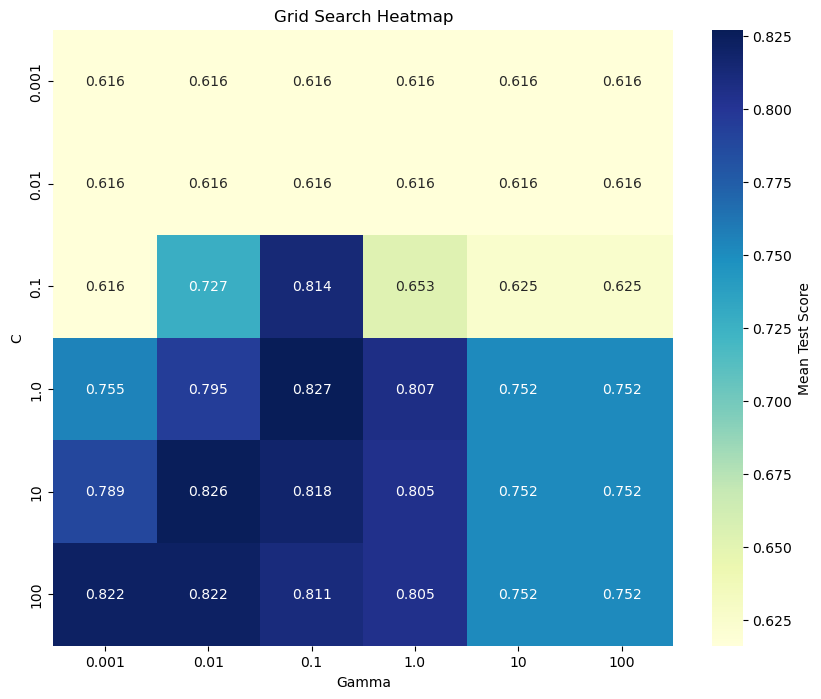

In [42]:
plt.figure(figsize=(10, 8))
sns.heatmap(heatmap_data, annot=True, cmap="YlGnBu", fmt=".3f", cbar_kws={'label': 'Mean Test Score'})
plt.title('Grid Search Heatmap')
plt.xlabel('Gamma')
plt.ylabel('C')
plt.show()

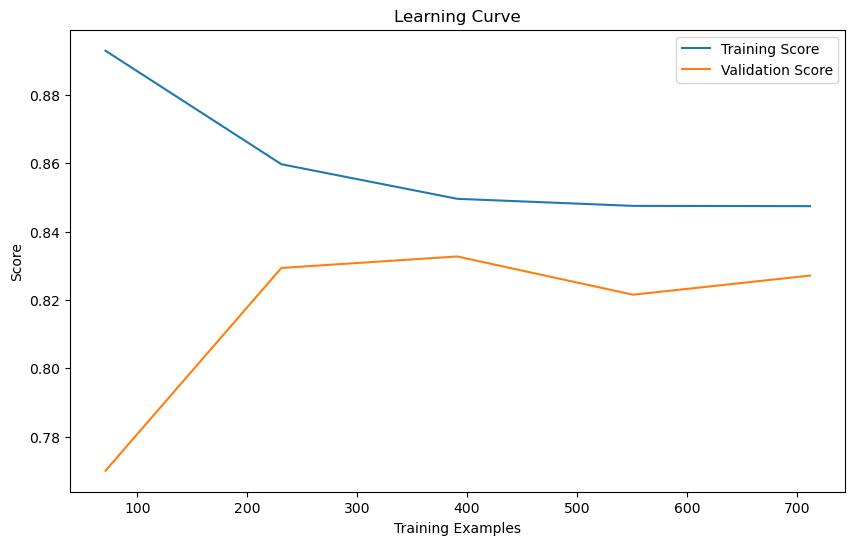

In [43]:
plt.figure(figsize=(10, 6))
plt.plot(train_sizes, np.mean(train_scores, axis=1), label='Training Score')
plt.plot(train_sizes, np.mean(test_scores, axis=1), label='Validation Score')
plt.title('Learning Curve')
plt.xlabel('Training Examples')
plt.ylabel('Score')
plt.legend()
plt.show()

In [44]:
MODEL = 0

if MODEL == 0:
    if not exists("model.joblib"):
        print("Copy a model to the root directory of this project")
    else:
        print("using previous model")
        model = load('model.joblib')
elif MODEL == 1:
    print("creating new SVC model...")
    model = make_pipeline(preprocessor, SVC(**best_params))
    model.fit(X_train, y_train)

    dump(model, 'model.joblib')
elif MODEL == 2:
    print("creating new Decision model...")
    model = make_pipeline(preprocessor, DecisionTreeClassifier())
    model.fit(X_train, y_train)

    dump(model, 'model.joblib')
elif MODEL == 3:
    print("creating new kNN model...")
    model = make_pipeline(preprocessor, KNeighborsClassifier())
    model.fit(X_train, y_train)

    dump(model, 'model.joblib')
elif MODEL == 4:
    print("creating a new Random Forest model...")
    model = make_pipeline(preprocessor, RandomForestClassifier())
    model.fit(X_train, y_train)

    dump(model, 'model.joblib')

if exists("model.joblib"):
    y_test = model.predict(X_test)

    submission_df = pd.read_csv('./dataset/gender_submission.csv')
    submission_df['Survived'] = y_test
    submission_df.to_csv('submission.csv', index=False)

Copy a model to the root directory of this project
